In [6]:
% cd /home/mayu-ot/durga/Experiments/loc_iparaphrasing/

/mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing


In [7]:
import numpy as np
import chainer
from chainer.iterators import SerialIterator
from func.datasets.datasets import BBoxDataset
from func.datasets.converters import cvrt_bbox
from chainercv.utils import bbox_iou
from IPython.html.widgets import IntProgress
from IPython.display import display

In [10]:
% matplotlib inline
import matplotlib.pyplot as plt

In [8]:
data = BBoxDataset('val')

ip = IntProgress(min=0, max=len(data))
display(ip)

ious = []

for i in range(len(data)):
    batch = [data[i]]
    gt_roi = batch[0][1]
    im, roi = cvrt_bbox(batch, None, aspect_band=2/3, offset_band=0.4)
    iou = bbox_iou(roi, gt_roi[None, :])[0]
    ious.append(iou)
    ip.value = i

IntProgress(value=0, max=11745)

0.708982545764155


(array([  6.,  12.,  30.,  74., 128., 162., 244., 268., 343., 401., 413.,
        453., 494., 557., 642., 749., 790., 768., 780., 792., 685., 601.,
        531., 407., 340., 277., 234., 170., 147., 247.]),
 array([0.07927207, 0.109963  , 0.14065393, 0.17134486, 0.20203579,
        0.23272672, 0.26341766, 0.29410859, 0.32479952, 0.35549045,
        0.38618138, 0.41687231, 0.44756324, 0.47825417, 0.5089451 ,
        0.53963603, 0.57032697, 0.6010179 , 0.63170883, 0.66239976,
        0.69309069, 0.72378162, 0.75447255, 0.78516348, 0.81585441,
        0.84654534, 0.87723628, 0.90792721, 0.93861814, 0.96930907,
        1.        ]),
 <a list of 30 Patch objects>)

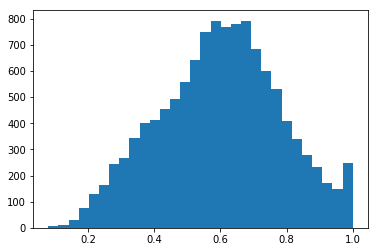

In [11]:
ious = np.asarray(ious)

print(np.sum(ious > .5) / len(ious))

plt.hist((ious), bins=30)

In [12]:
ious.mean()

0.5991176

In [3]:
def get_agg_roi_df(split):
    gtroi_df = pd.read_csv('data/gt_roi_cord_%s.csv' % split)
    groups = gtroi_df.groupby(['image', 'org_phrase'])
    agg_df = groups.agg({
               'ymin': np.min,
               'xmin': np.min,
               'ymax': np.max,
               'xmax': np.max})
    return agg_df

In [4]:
from IPython.html.widgets import IntProgress
from IPython.display import display
from chainercv.utils import bbox_iou
import pandas as pd
import imageio
from chainer.dataset.convert import to_device

class CordDataset(chainer.dataset.DatasetMixin):
    def __init__(self, split):
        self.df = get_agg_roi_df(split)
#         self.df = pd.read_csv('data/gt_roi_cord_%s.csv'%split)
    
    def __len__(self):
        return len(self.df)
    
    def get_example(self, i):
        im_id, _ = self.df.iloc[i].name
        im = imageio.imread('data/flickr30k-images/%i.jpg'%im_id)
        im = np.asarray(im)
        gt_roi = self.df.iloc[i][['ymin', 'xmin', 'ymax', 'xmax']]
        gt_roi = np.asarray(gt_roi)
        return im, gt_roi
    
def cvrt_coord(batch, device=None):
    im = [b[0].transpose(2, 0, 1).astype('f') for b in batch]
    im_shape = np.asarray([x.shape for x in im])
    roi = [b[1] for b in batch]
    j_rois = jitter_bbox(roi, im_shape)
    
    if device is not None:
        im = [to_device(device, x) for x in im]
        j_rois = to_device(device, j_rois)
    return im, j_rois

/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [6]:
from func.datasets.converters import jitter_bbox
from func.datasets.datasets import PreCompFeatDataset
import sys
sys.path.append('script/training/')
from train_wt_frcnn import iParaphraseNet, my_converter

In [6]:
def save_jitter_frcnn_feat(split):
    device = 1
    model = iParaphraseNet()
    chainer.cuda.get_device_from_id(device).use()
    model.to_gpu()

    data = CordDataset(split)
    data_itr = SerialIterator(data, batch_size=100, repeat=False, shuffle=False)

    feat = np.zeros((len(data), 4096)).astype('f')
    roi_indices = model.xp.zeros((1,)).astype('i')
    b_size = 30

    for i in range(len(data)):
        batch = [data[i]]
        im, roi = cvrt_coord(batch, device)
        with chainer.no_backprop_mode(), chainer.using_config('train', False):
            im = im[0]
            y = model.base_net.extract(im[None, :], roi, roi_indices)

        y.to_cpu()
        feat[i,:] = y.data[:]

    np.save('data/region_feat/jitter_roi-frcnn/%s'%split, feat)

In [7]:
save_jitter_frcnn_feat('val')

In [38]:
from IPython.html.widgets import IntProgress
from IPython.display import display
from chainercv.utils import bbox_iou
import pandas as pd
import imageio

class CordDataset(chainer.dataset.DatasetMixin):
    def __init__(self, split):
        self.df = pd.read_csv('data/gt_roi_cord_%s.csv'%split)
    
    def __len__(self):
        return len(self.df)
    
    def get_example(self, i):
        im_id = self.df.iloc[i].image
        im = imageio.imread('data/flickr30k-images/%i.jpg'%im_id)
        gt_roi = self.df.iloc[i][['ymin', 'xmin', 'ymax', 'xmax']]
        gt_roi = np.asarray(gt_roi)
        return im, gt_roi

split = 'val'

data = CordDataset(split)

ip = IntProgress(min=0, max=len(data))
display(ip)

ious = []
for i in range(len(data))[::100]:
    im, roi = data[i]
    im = im.transpose(2, 0, 1)
    roi = roi[None, :]
    j_roi = jitter_bbox(roi, np.asarray(im.shape)[None, :], aspect_band=2/3, offset_band=0.4)
    ious.append(bbox_iou(roi, j_roi).ravel()[0])
    ip.value = i

IntProgress(value=0, max=18523)

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([ 2.,  1.,  1.,  3.,  1.,  0.,  0.,  2.,  3.,  8.,  4.,  1.,  3.,
         4.,  3.,  3.,  6.,  3.,  6.,  2.,  5.,  6.,  5.,  5.,  5.,  4.,
         8.,  2., 12.,  9.,  7.,  5.,  5.,  3.,  6.,  7.,  5.,  6.,  1.,
         6.,  5.,  0.,  4.,  2.,  3.,  0.,  0.,  1.,  1.,  2.]),
 array([0.15207581, 0.16784416, 0.1836125 , 0.19938085, 0.2151492 ,
        0.23091755, 0.24668589, 0.26245424, 0.27822259, 0.29399093,
        0.30975928, 0.32552763, 0.34129598, 0.35706432, 0.37283267,
        0.38860102, 0.40436937, 0.42013771, 0.43590606, 0.45167441,
        0.46744276, 0.4832111 , 0.49897945, 0.5147478 , 0.53051614,
        0.54628449, 0.56205284, 0.57782119, 0.59358953, 0.60935788,
        0.62512623, 0.64089458, 0.65666292, 0.67243127, 0.68819962,
        0.70396797, 0.71973631, 0.73550466, 0.75127301, 0.76704136,
        0.7828097 , 0.79857805, 0.8143464 , 0.83011474, 0.84588309,
        0.86165144, 0.87741979, 0.89318813, 0.90895648, 0.92472483,
        0.94049318]),
 <a list of 50

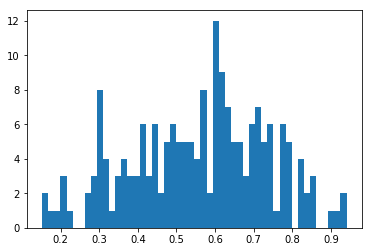

In [39]:
plt.hist(np.asarray(ious).ravel(), bins=50)

In [40]:
np.sum(np.asarray(ious) > .5) / len(ious)

0.6397849462365591